In [1]:
%matplotlib inline

import sys, os
sys.argv = [''] #fix parser issue

import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from tqdm import trange
import matplotlib.pyplot as plt

from networks import CNN
from parser import args
from summary import Summary
import utils


2023-02-08 18:23:01.484138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:23:02.234244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-08 18:23:02.234453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-08 18:23:02.234461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
args.eval_during_training = True

In [3]:
def eval_model(network, criterion, test_loader, summary = None):
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='Accuracy')
    labels = []
    test_iter = iter(test_loader)
#     for eval_steps in trange(len(test_loader), leave=False, file=sys.stdout,
#                             desc='   Evaluation Progress', unit_scale=False):
    for eval_steps in range(len(test_loader)):
        input, target = next(test_iter)

        if(len(input.shape) <= 3):
            input = tf.expand_dims(input, -1)

        pred = network(input)
        labels += [tf.argmax(pred, axis=1)]
        loss = criterion(target, pred)
        accuracy(target, pred)
        if(summary is not None):
            summary.step(loss, target, pred, eval=True)
    return accuracy.result() * 100, np.array(labels)

In [4]:
# uncomment this to run a single experiment per kernel run
# otherwise the trace needs to be reset for tf.function between different experiments
#@tf.function
def training_step(network, criterion, data, summary, optimizer):
    input, target = data
    loss = 0
    with tf.GradientTape() as tape:
        pred = network(input)
        loss = criterion(target, pred)

    gradients = tape.gradient(loss, network.trainable_variables,
                                    unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(gradients, network.trainable_variables))

    summary.step(loss, target, pred, eval=False)

    del tape


In [5]:
def train(network, optimizer, criterion, checkpoint, checkpoint_manager,
            train_loader, test_loader, summary):

    training_steps = len(train_loader)
    steps_done = checkpoint.step.numpy() + 1
    train_iter = iter(train_loader)
    x, y = tf.random.uniform([args.batch_size,28,28,1]), tf.random.uniform([args.batch_size,1])
#     t_step = tf.function(training_step).get_concrete_function(network, criterion, (x,y),summary, optimizer)
        
    for steps in trange(int(steps_done), training_steps, desc='Training Progress', file=sys.stdout):
        # fetch data
        input, target = next(train_iter)

        # expand input shape in case of only 1 channel
        if(len(input.shape) <= 3):
            input = tf.expand_dims(input, -1)
#         t_step(network, criterion,(input, target),summary)
        training_step(network, criterion,(input, target),summary,optimizer)

        # evaluation step
        if(args.eval_during_training and steps > 0
                    and steps % args.num_eval_steps == 0):
            eval_model(network, criterion, test_loader, summary)
            summary.write(steps, eval=True)

        #  log training accuracy and update checkpoint
        if(steps % args.num_summary_steps == 0):
            summary.write(steps, eval=False)
            if(summary.max_test_accuracy <= checkpoint.best_test):
                checkpoint.best_train.assign(summary.max_train_accuracy)
                checkpoint.best_test.assign(summary.max_test_accuracy)
                checkpoint.step.assign(steps)
                checkpoint_manager.save(checkpoint_number=steps//args.num_summary_steps)

    # evaluate model after finishing training epochs
    eval_model(network, criterion, test_loader,summary)

    if(summary.max_test_accuracy <= checkpoint.best_test):
        checkpoint.best_train.assign(summary.max_train_accuracy)
        checkpoint.best_test.assign(summary.max_test_accuracy)
        checkpoint.step.assign(steps)
        checkpoint_manager.save(checkpoint_number=steps//args.num_summary_steps)

    summary.write(training_steps + 1, eval=True)
    summary.write(training_steps + 1, eval=False)

    print('Training accuracy: ', summary.max_train_accuracy)
    print('Evaluation accuracy: ', summary.max_test_accuracy)
    summary.writer.close()

In [6]:
# Make sure computing on cuda
print('GPUs found: ', tf.config.list_physical_devices('GPU'))

GPUs found:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-02-08 18:23:07.601996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 18:23:07.608359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 18:23:07.608681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
tf.random.set_seed(args.random_seed)

# Training a 'client' model on MNIST

### Random initialization

In [ ]:
experiment = 'c_mnist'
args.dataset = 'mnist'

exp_path = os.path.join(args.model_dir, experiment)
utils.initialize_dirs(exp_path)

summary = Summary(experiment)
network = CNN()
optimizer = utils.initialize_optimizer()
criterion = utils.initialize_criterion()
checkpoint, checkpoint_manager = utils.initialize_checkpoint(network, optimizer, exp_path)

# data loading
train_loader, test_loader, targets = utils.initialize_dataloaders()

#train client network
train(network, optimizer, criterion, checkpoint, checkpoint_manager, train_loader, test_loader, summary)
accuracy, predictions = eval_model(network, criterion, test_loader)

p, r, f, s = precision_recall_fscore_support(targets, predictions.reshape(-1), average=None,labels=np.arange(20))
    
print('Random Initialization MNIST model:')
print(accuracy.numpy())
print(r)

2023-02-08 17:47:20.454049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 17:47:20.454819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 17:47:20.455421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 17:47:20.455888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training Progress:   0%|                             | 0/131249 [00:00<?, ?it/s]

2023-02-08 17:47:24.086635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-02-08 17:47:25.025995: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 17:47:26.842348: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa1edeb5b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-08 17:47:26.842379: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-02-08 17:47:26.889332: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-08 17:47:27.118048: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 17:47:27.191463: I tensorflow/compiler/jit/xla_compilati

Training Progress:   1%|▏                 | 967/131249 [00:08<05:21, 405.16it/s]

2023-02-08 17:47:30.530646: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


Training Progress: 100%|███████████████| 131249/131249 [05:23<00:00, 405.66it/s]
Training accuracy:  tf.Tensor(100.0, shape=(), dtype=float32)
Evaluation accuracy:  tf.Tensor(98.869995, shape=(), dtype=float32)
Random Initialization MNIST model:
98.869995
[0.99489796 0.99735683 0.98934109 0.99405941 0.99185336 0.9809417
 0.98643006 0.9844358  0.98151951 0.98414272 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


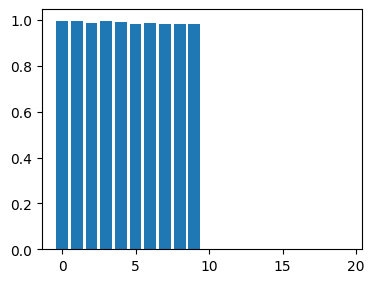

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.bar(np.arange(20),r)
plt.show()

### Set seed for initialization

In [8]:
experiment = 'c_mnist_setseed'
args.dataset = 'mnist'

exp_path = os.path.join(args.model_dir, experiment)
utils.initialize_dirs(exp_path)

summary = Summary(experiment)
network = CNN(42)
optimizer = utils.initialize_optimizer()
criterion = utils.initialize_criterion()
checkpoint, checkpoint_manager = utils.initialize_checkpoint(network, optimizer, exp_path)

# data loading
train_loader, test_loader, targets = utils.initialize_dataloaders()

#train client network
train(network, optimizer, criterion, checkpoint, checkpoint_manager, train_loader, test_loader, summary)
accuracy, predictions = eval_model(network, criterion, test_loader)
p, r, f, s = precision_recall_fscore_support(targets, predictions.reshape(-1), average=None,labels=np.arange(20))
    
print('Set Seed Initialization MNIST model:')
print(accuracy.numpy())
print(r)

2023-02-08 18:11:36.970304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:11:36.970750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 18:11:36.971184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 18:11:36.971498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training Progress:   0%|                             | 0/131249 [00:00<?, ?it/s]

2023-02-08 18:11:39.734147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-02-08 18:11:40.645558: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 18:11:42.145531: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7b7e9a0380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-08 18:11:42.145557: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-02-08 18:11:42.176713: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-08 18:11:42.430066: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 18:11:42.481089: I tensorflow/compiler/jit/xla_compilati

Training Progress: 100%|███████████████| 131249/131249 [05:05<00:00, 429.00it/s]
Training accuracy:  tf.Tensor(100.0, shape=(), dtype=float32)
Evaluation accuracy:  tf.Tensor(98.92, shape=(), dtype=float32)
Set Seed Initialization MNIST model:
98.85
[0.99285714 0.99735683 0.98643411 0.98415842 0.99185336 0.98430493
 0.98538622 0.98929961 0.98870637 0.98315164 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


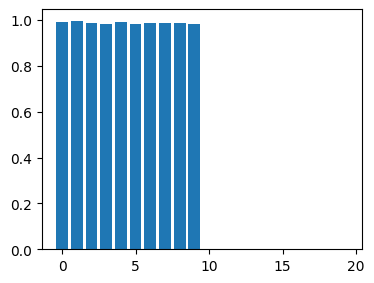

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.bar(np.arange(20),r)
plt.show()

# Training a 'client' model on Fashion MNIST

### Random initialization

In [8]:
tf.keras.backend.clear_session()
experiment = 'c_fmnist'
args.dataset = 'fmnist'

exp_path = os.path.join(args.model_dir, experiment)
utils.initialize_dirs(exp_path)

# data loading
train_loader, test_loader, targets = utils.initialize_dataloaders()

summary = Summary(experiment)
network = CNN()
network.build([1,28,28,1])
optimizer = utils.initialize_optimizer()
criterion = utils.initialize_criterion()
checkpoint, checkpoint_manager = utils.initialize_checkpoint(network, optimizer, exp_path)


#train client network
train(network, optimizer, criterion, checkpoint, checkpoint_manager, train_loader, test_loader, summary)
accuracy, predictions = eval_model(network, criterion, test_loader)
p, r, f, s = precision_recall_fscore_support(targets, predictions.reshape(-1), average=None,labels=np.arange(20))
    
print('Random Initialization Fashion MNIST model:')
print(accuracy.numpy())
print(r)

2023-02-08 18:17:42.265685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:17:42.266149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 18:17:42.266544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 18:17:42.266819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training Progress:   0%|                             | 0/131249 [00:00<?, ?it/s]

2023-02-08 18:17:44.323139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-02-08 18:17:44.762138: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 18:17:45.376277: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb2f40118f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-08 18:17:45.376304: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-02-08 18:17:45.379794: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-08 18:17:45.449172: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 18:17:45.498629: I tensorflow/compiler/jit/xla_compilati

Training Progress: 100%|███████████████| 131249/131249 [05:00<00:00, 436.20it/s]
Training accuracy:  tf.Tensor(98.375, shape=(), dtype=float32)
Evaluation accuracy:  tf.Tensor(90.6, shape=(), dtype=float32)
Random Initialization Fashion MNIST model:
90.35
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.879 0.981
 0.804 0.894 0.888 0.973 0.707 0.973 0.977 0.959]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


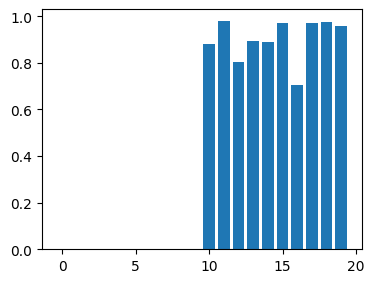

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.bar(np.arange(20),r)
plt.show()

### Set seed for initialization

In [8]:
experiment = 'c_fmnist_setseed'
args.dataset = 'fmnist'

exp_path = os.path.join(args.model_dir, experiment)
utils.initialize_dirs(exp_path)

summary = Summary(experiment)
network = CNN(42)
optimizer = utils.initialize_optimizer()
criterion = utils.initialize_criterion()
checkpoint, checkpoint_manager = utils.initialize_checkpoint(network, optimizer, exp_path)

# data loading
train_loader, test_loader, targets = utils.initialize_dataloaders()

#train client network
train(network, optimizer, criterion, checkpoint, checkpoint_manager, train_loader, test_loader, summary)
accuracy, predictions = eval_model(network, criterion, test_loader)
p, r, f, s = precision_recall_fscore_support(targets, predictions.reshape(-1), average=None,labels=np.arange(20))
    
print('Set Seed Initialization MNIST model:')
print(accuracy.numpy())
print(r)

2023-02-08 18:23:28.406981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:23:28.407521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 18:23:28.408142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 18:23:28.408585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training Progress:   0%|                             | 0/131249 [00:00<?, ?it/s]

2023-02-08 18:23:30.700929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-02-08 18:23:31.104010: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 18:23:31.659821: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fdca9752100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-08 18:23:31.659839: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-02-08 18:23:31.663210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-08 18:23:31.727611: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 18:23:31.775549: I tensorflow/compiler/jit/xla_compilati

Training Progress: 100%|███████████████| 131249/131249 [05:06<00:00, 428.79it/s]
Training accuracy:  tf.Tensor(98.341835, shape=(), dtype=float32)
Evaluation accuracy:  tf.Tensor(91.119995, shape=(), dtype=float32)
Set Seed Initialization MNIST model:
90.96
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.878 0.983
 0.854 0.887 0.885 0.97  0.722 0.98  0.974 0.963]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


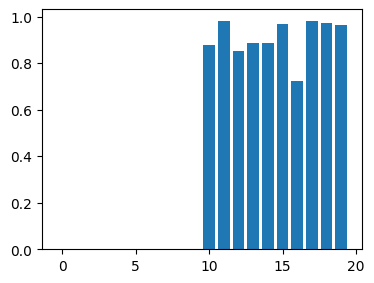

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.bar(np.arange(20),r)
plt.show()

## Create dataset containing both MNIST and FMNIST

In [26]:
mnist = tf.keras.datasets.mnist
(m_x_train, m_y_train), (m_x_test, m_y_test) = mnist.load_data()
m_x_train = tf.cast(m_x_train, dtype=tf.float32)
m_x_test = tf.cast(m_x_test, dtype=tf.float32)
m_x_train, m_x_test = m_x_train / 255.0, m_x_test / 255.0

fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train_old), (x_test, y_test_old) = fmnist.load_data()
y_train = y_train_old + 10
y_test = y_test_old + 10
x_train = tf.cast(x_train, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)
x_train, x_test = x_train / 255.0, x_test / 255.0

f_x_train = tf.concat([x_train, m_x_train],0)
f_x_test = tf.concat([x_test, m_x_test],0)
f_y_train = tf.concat([y_train, m_y_train],0)
f_y_test = tf.concat([y_test, m_y_test],0)

full_train_loader = tf.data.Dataset.from_tensor_slices((f_x_train, f_y_train)).shuffle(x_train.shape[0]).repeat(args.epochs).batch(args.batch_size)
full_test_loader = tf.data.Dataset.from_tensor_slices((f_x_test, f_y_test)).batch(args.eval_batch_size)

2023-02-08 18:43:27.999194: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 376320000 exceeds 10% of free system memory.


In [27]:
clients = ['c_mnist', 'c_fmnist']
clients_setseed = ['c_mnist_setseed', 'c_fmnist_setseed']

n_clients = len(clients)

# Creating Federated Model

In [28]:
federal_model = CNN()
federal_model(tf.random.uniform([1,28,28,1])) #initialize network

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[-0.04428594,  0.0305936 , -0.01058867, -0.05268055,  0.01184747,
        -0.05283582, -0.09278443,  0.00301115, -0.01669198, -0.00127565,
         0.02928724, -0.01078262, -0.02904074,  0.0229306 ,  0.01424787,
        -0.00145532, -0.05813391, -0.09276426, -0.00037723,  0.00061042]],
      dtype=float32)>

## Collecting client models

### Randomly initialized models

In [35]:
cmodels=[]
x = tf.random.uniform([1,28,28,1])
for c in clients:
        c_path = os.path.join(args.model_dir, c)
        c_network = CNN()
        c_optimizer = utils.initialize_optimizer()
        c_checkpoint, c_checkpoint_manager = utils.initialize_checkpoint(c_network, c_optimizer, c_path)
        c_network(x) # restore deferred variables
        cmodels += [c_network]

Resuming training from trained_models/c_mnist/ckpt-4...
Resuming training from trained_models/c_fmnist/ckpt-4...


### Averaging models initialized with the same weights

In [42]:
cmodels=[]
x = tf.random.uniform([1,28,28,1])
for c in clients_setseed:
        c_path = os.path.join(args.model_dir, c)
        c_network = CNN()
        c_optimizer = utils.initialize_optimizer()
        c_checkpoint, c_checkpoint_manager = utils.initialize_checkpoint(c_network, c_optimizer, c_path)
        c_network(x) # restore deferred variables
        cmodels += [c_network]

Resuming training from trained_models/c_mnist_setseed/ckpt-4...
Resuming training from trained_models/c_fmnist_setseed/ckpt-4...


## Aggregating the weights of the models

In [43]:
conv1 = tf.zeros_like(federal_model.conv1.kernel)
conv1_b = tf.zeros_like(federal_model.conv1.bias)

conv2 = tf.zeros_like(federal_model.conv2.kernel)
conv2_b = tf.zeros_like(federal_model.conv2.bias)

fc1 = tf.zeros_like(federal_model.fc1.kernel)
fc1_b = tf.zeros_like(federal_model.fc1.bias)
                        
out = tf.zeros_like(federal_model.out.kernel)
out_b = tf.zeros_like(federal_model.out.bias)
for i in range(len(cmodels)):
    conv1 += cmodels[i].conv1.kernel / len(cmodels)
    conv1_b += cmodels[i].conv1.bias / len(cmodels)
    
    conv2 += cmodels[i].conv2.kernel / len(cmodels)
    conv2_b += cmodels[i].conv2.bias / len(cmodels)
    
    fc1 += cmodels[i].fc1.kernel / len(cmodels)
    fc1_b += cmodels[i].fc1.bias / len(cmodels)
    
    out += cmodels[i].out.kernel / len(cmodels)
    out_b += cmodels[i].out.bias / len(cmodels)
    

## Federated model equals the average weight of the client models

In [44]:
federal_model.conv1.kernel = conv1
federal_model.conv1.bias = conv1_b

federal_model.conv2.kernel = conv2
federal_model.conv2.bias = conv2_b

federal_model.fc1.kernel = fc1
federal_model.fc1.bias = fc1_b

federal_model.out.kernel = out
federal_model.out.bias = out_b

In [45]:
criterion = utils.initialize_criterion()

### Random Initialization

20.625
[0.         0.51365639 0.02034884 0.0950495  0.         0.28475336
 0.00417537 0.         0.87474333 0.         0.         0.
 0.         0.         0.         0.361      0.961      0.993
 0.         0.        ]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


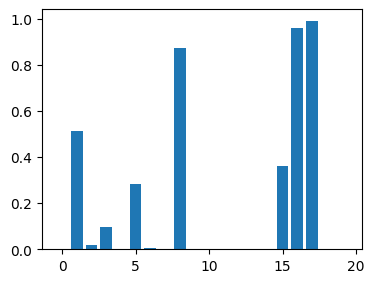

In [41]:
# evaluate federated network
accuracy, labels = eval_model(federal_model, criterion, full_test_loader)
p, r, f, s = precision_recall_fscore_support(f_y_test, labels.reshape(-1), average=None,labels=np.arange(20))

print(accuracy.numpy())
print(r)

fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.bar(np.arange(20),r)
plt.show()

### Set seed Initialization

41.2
[0.4        0.97092511 0.60562016 0.85841584 0.76069246 0.53475336
 0.79645094 0.         0.67864476 0.91278494 0.633      0.077
 0.         0.         0.         0.959      0.         0.
 0.016      0.        ]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


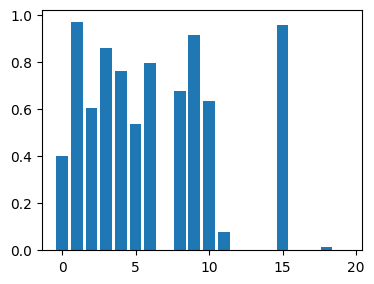

In [47]:
# evaluate federated network
accuracy, labels = eval_model(federal_model, criterion, full_test_loader)
p, r, f, s = precision_recall_fscore_support(f_y_test, labels.reshape(-1), average=None,labels=np.arange(20))

print(accuracy.numpy())
print(r)

fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.bar(np.arange(20),r)
plt.show()

## Averaging only the last layer

### Random Initialization

Client model 0 :
accuracy 24.165
[0.49081633 0.92246696 0.20736434 0.94653465 0.09368635 0.90807175
 0.11899791 0.01848249 0.6026694  0.50842418 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


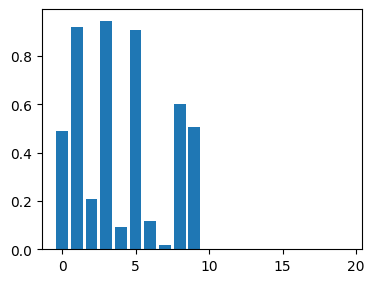

Client model 1 :
accuracy 15.870001
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.662 0.389
 0.    0.    0.    0.266 0.858 0.999 0.    0.   ]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


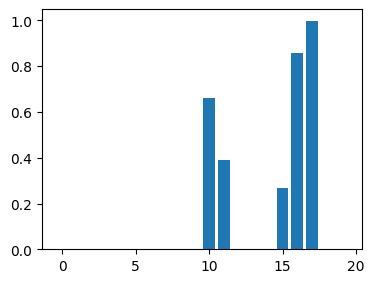

In [19]:
for i in range(len(cmodels)):
    federal_model.conv1.kernel = cmodels[i].conv1.kernel
    federal_model.conv1.bias = cmodels[i].conv1.bias

    federal_model.conv2.kernel = cmodels[i].conv2.kernel
    federal_model.conv2.bias = cmodels[i].conv2.bias

    federal_model.fc1.kernel = cmodels[i].fc1.kernel
    federal_model.fc1.bias = cmodels[i].fc1.bias

    federal_model.out.kernel = out
    federal_model.out.bias = out_b

    # evaluate federated network
    accuracy, labels = eval_model(federal_model, criterion, full_test_loader)
    p, r, f, s = precision_recall_fscore_support(f_y_test, labels.reshape(-1), average=None,labels=np.arange(20))
    
    print('Client model', i, ':')
    print('accuracy', accuracy.numpy())
    print(r)
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,0.5,0.5])
    ax.bar(np.arange(20),r)
    plt.show()

### Set seed initialization

Client model 0 :
accuracy 44.73
[0.97653061 0.98942731 0.88178295 0.85247525 0.95519348 0.83295964
 0.92588727 0.89883268 0.86344969 0.75520317 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


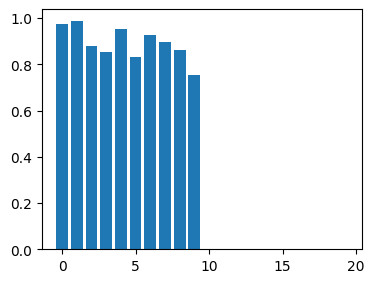

Client model 1 :
accuracy 37.835
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.579 0.91
 0.299 0.841 0.786 0.907 0.593 0.862 0.887 0.903]


/home/anwar/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


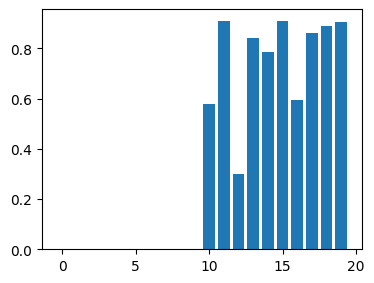

In [49]:
for i in range(len(cmodels)):
    federal_model.conv1.kernel = cmodels[i].conv1.kernel
    federal_model.conv1.bias = cmodels[i].conv1.bias

    federal_model.conv2.kernel = cmodels[i].conv2.kernel
    federal_model.conv2.bias = cmodels[i].conv2.bias

    federal_model.fc1.kernel = cmodels[i].fc1.kernel
    federal_model.fc1.bias = cmodels[i].fc1.bias

    federal_model.out.kernel = out
    federal_model.out.bias = out_b

    # evaluate federated network
    accuracy, labels = eval_model(federal_model, criterion, full_test_loader)
    p, r, f, s = precision_recall_fscore_support(f_y_test, labels.reshape(-1), average=None,labels=np.arange(20))
    
    print('Client model', i, ':')
    print('accuracy', accuracy.numpy())
    print(r)
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,0.5,0.5])
    ax.bar(np.arange(20),r)
    plt.show()